# Visualizing and prediciting the Singapore housing resale market

*By: James Soh*

### Objectives

1. Explore and analyse the Singapore housing resale market. 

2. Prepare and clean the dataset for prediction models

3. Create a model to predict Singapore housing resale prices

### Sources

Data from: https://data.gov.sg/dataset/resale-flat-prices

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df = pd.read_csv('resale-flat-prices-based-on-registration-date-from-march-2012-onwards.csv')
pd.set_option('display.max_columns',100)
sns.set_style('whitegrid')

%matplotlib inline


In [2]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0


# 1. Exploratory Data Analysis

### 1.1 Which areas are the most / least expensive? 

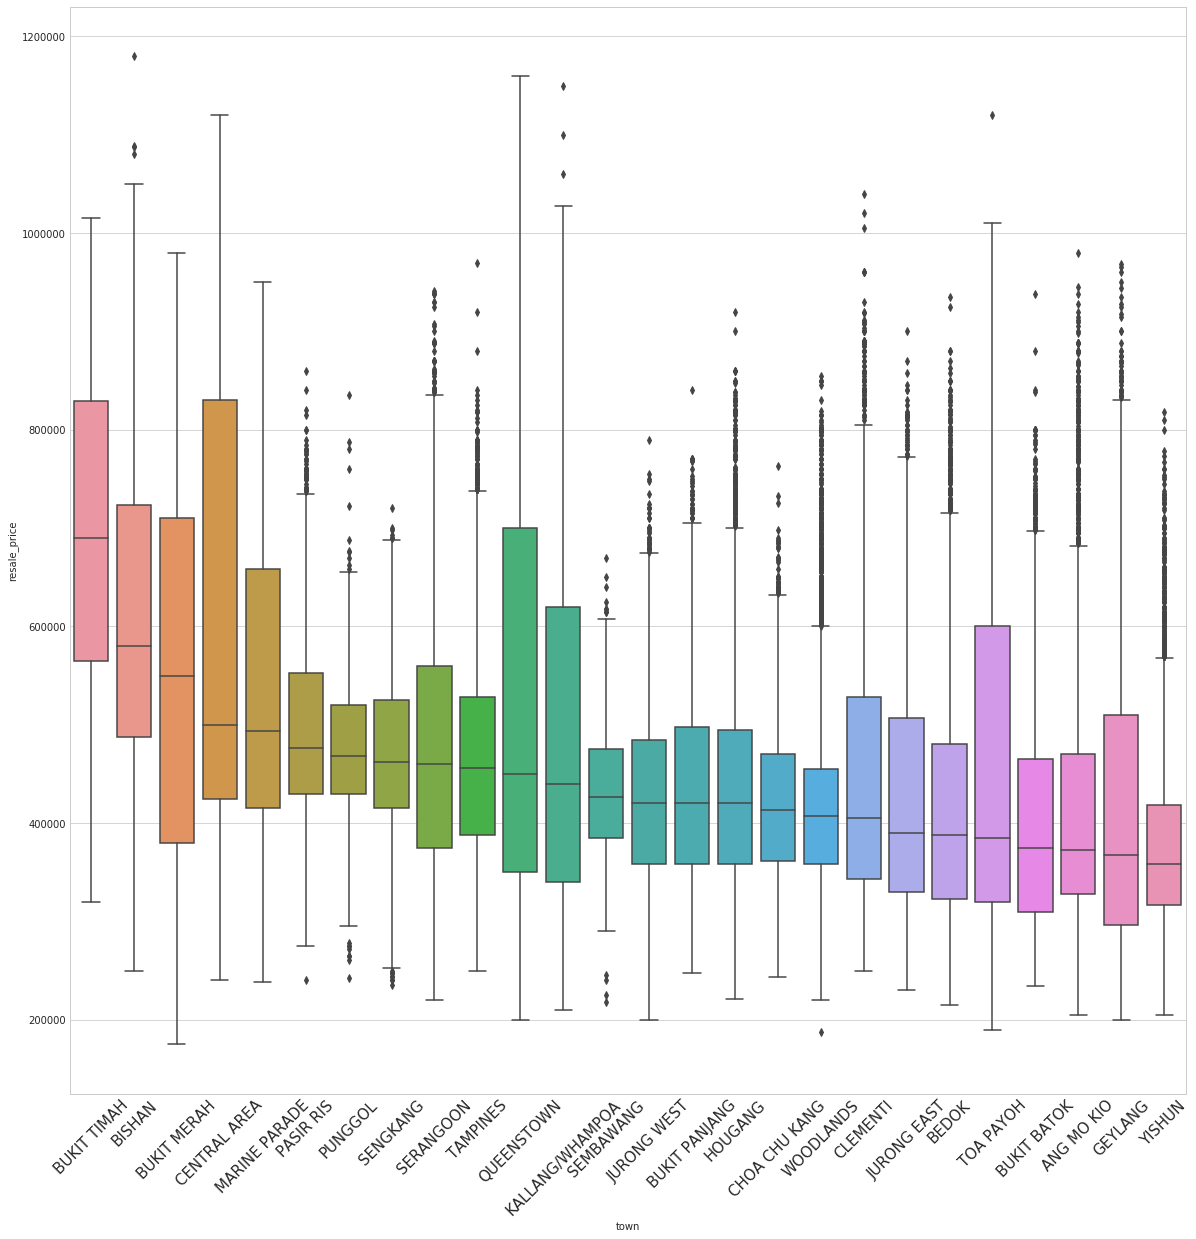

In [3]:
town_group = df.groupby(['town'])
order_town = town_group.median().sort_values('resale_price', ascending=False).index

plt.figure(figsize=(20,20))
plt.xticks(rotation='45', fontsize=15)

sns.boxplot(x=df.town, y=df.resale_price, order=order_town)

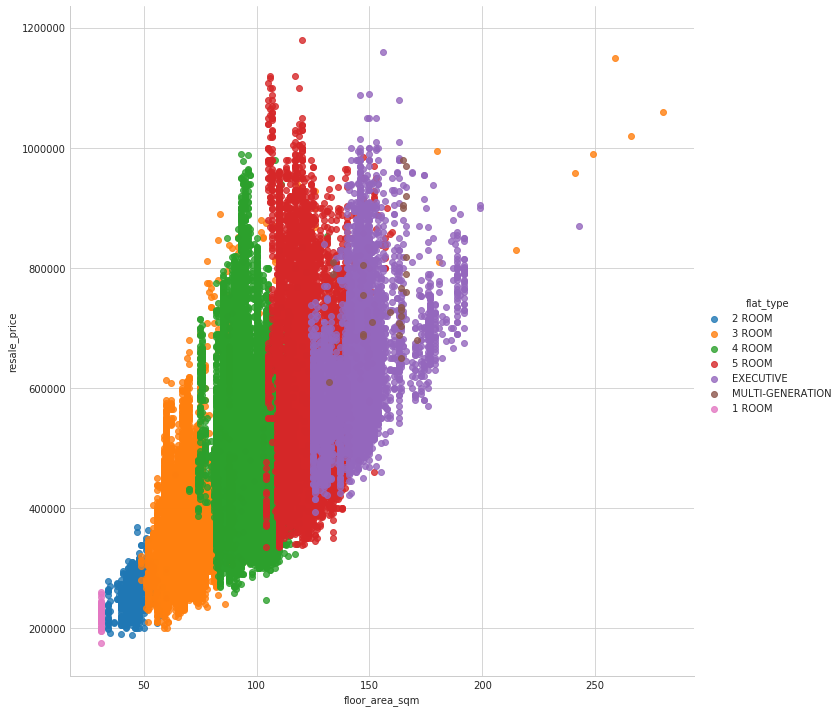

In [4]:
#plt.figure(figsize=(13,13))

sns.lmplot(x='floor_area_sqm', y='resale_price',hue='flat_type', data=df,
           fit_reg=False, size=10)

In [5]:
town_group = df.groupby(['town'])

town_group.median()

,floor_area_sqm,lease_commence_date,resale_price
town,,,
ANG MO KIO,74.0,1980,373000.0
BEDOK,84.0,1980,388000.0
BISHAN,105.0,1988,580000.0
BUKIT BATOK,90.0,1986,375000.0
BUKIT MERAH,86.0,1983,550000.0
BUKIT PANJANG,104.0,1998,420000.0
BUKIT TIMAH,104.0,1988,690000.0
CENTRAL AREA,76.0,1983,500000.0
CHOA CHU KANG,108.0,1996,413000.0


### A suspicious category: What exactly is "Central Area"? Let's take a closer look.

Hmm, the properties in 'CENTRAL AREA' are actually in different areas in Singapore (Some properties in Cantonement Road and Little India are tagged under 'CENTRAL AREA'.). (See below for breakdown) This explains the large range in price for 'CENTRAL AREA' in the boxplot above. 

At this point, I'm faced with a a few choices.

1. Leave this category as it is. (Don't do anything)

2. Drop all of these records as the number of these records are statistically insignificant (only forming .8% of the whole dataset),

3. Try to engineer categories that reflect the reality of where those properties are.

We will come back to this later when we are preparing our data.

In [6]:
print 'Number of records under Central Area: %s '  %len(df.loc[df.town == 'CENTRAL AREA'])
print 'Total Number of Records: %s' %len(df)
print 'The records in Central Area form %s  of our data' % str(len(df.loc[df.town == 'CENTRAL AREA']) / float(len(df)))

print 
print '=== Breakdown of properties tagged under CENTRAL AREA ==='
print df.loc[df.town == 'CENTRAL AREA']['street_name'].value_counts()

Number of records under Central Area: 849 
Total Number of Records: 102100
The records in Central Area form 0.00831537708129  of our data

=== Breakdown of properties tagged under CENTRAL AREA ===
CANTONMENT RD     243
TG PAGAR PLAZA     96
UPP CROSS ST       67
JLN KUKOH          46
KLANG LANE         42
SELEGIE RD         39
ROWELL RD          38
VEERASAMY RD       38
KELANTAN RD        33
WATERLOO ST        33
BUFFALO RD         30
SAGO LANE          30
QUEEN ST           28
SMITH ST           22
BAIN ST            18
CHIN SWEE RD       12
CHANDER RD         12
NEW MKT RD         11
KRETA AYER RD       6
JLN BERSEH          5
Name: street_name, dtype: int64


### A more interesting metric: Which areas of Singapore cost the most per square meter?

Average resale price in each town is interesting, but doesn't tell the whole story. Eg, Bukit Timah could possibly be full of large houses, hence pushing up the average resale price of the area.

When we consider cost per floor area square meter, there are some interesting shifts in the rank of most expensive. For instance, Yishun no longer became the least expensive town, and Geylang went from 2nd least expensive, to in the top 50% most expensive.

In [7]:
df['resale_price_per_floor_area_sqm'] = df.resale_price / df.floor_area_sqm

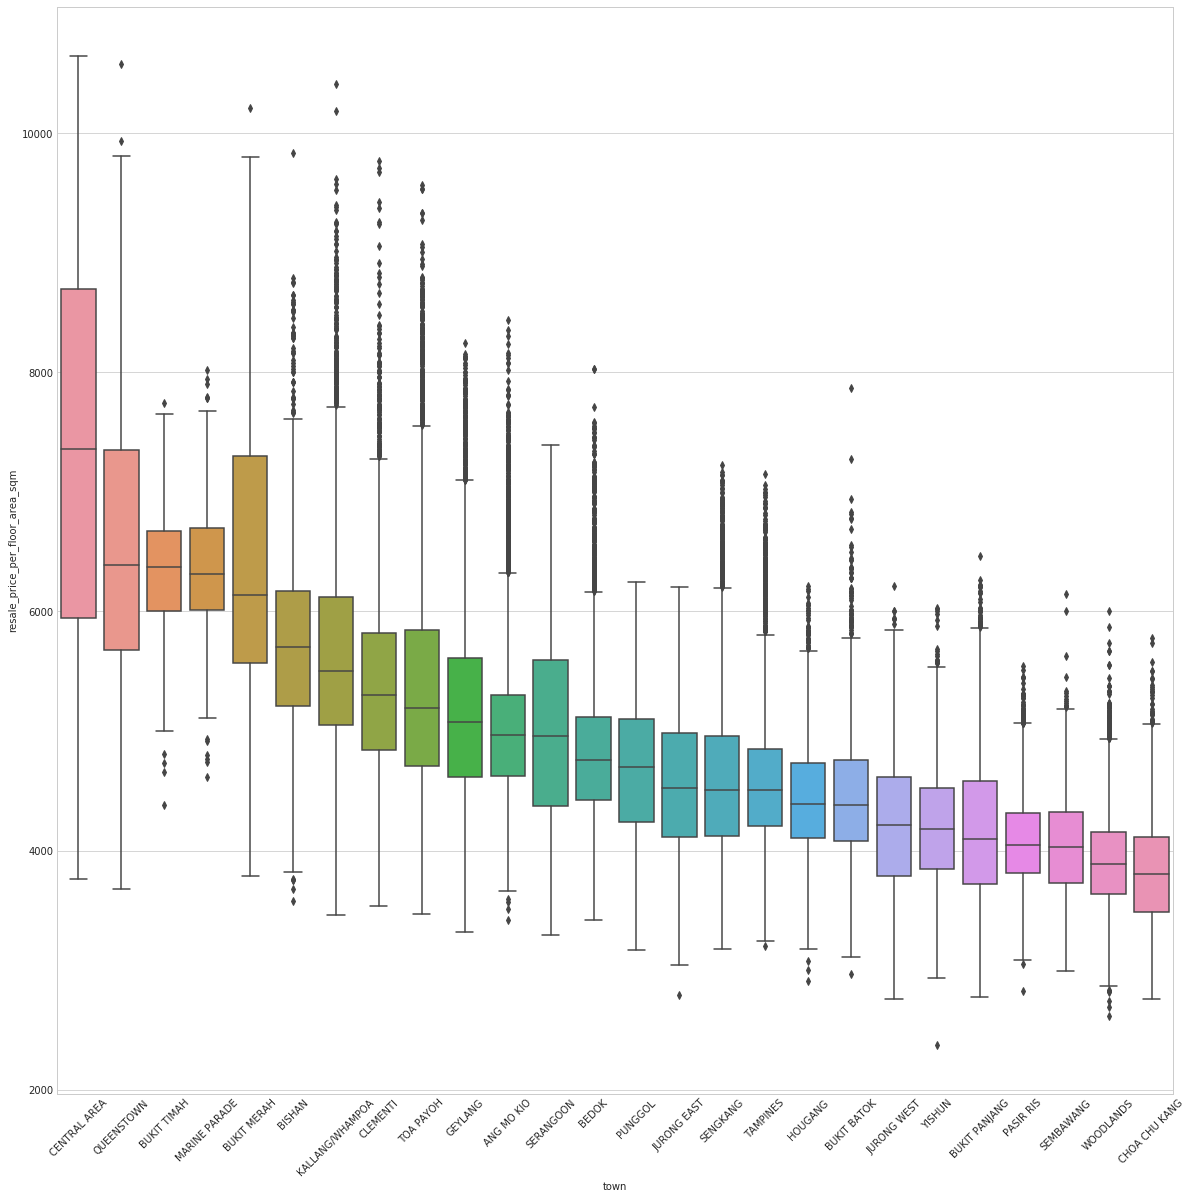

In [8]:
town_group2 = df.groupby('town')
order_psm = town_group2.median().sort_values('resale_price_per_floor_area_sqm', ascending=False).index

plt.figure(figsize = (20,20))
plt.xticks(fontsize = 10, rotation=45)
sns.boxplot(x=df.town, y=df.resale_price_per_floor_area_sqm, order=order_psm)



In [9]:
print 'Ranking of towns resale prices'

pd.DataFrame({'With value per sq meter':order_psm, 'Without value per sq meter ':order_town})

Ranking of towns resale prices


,With value per sq meter,Without value per sq meter
0,CENTRAL AREA,BUKIT TIMAH
1,QUEENSTOWN,BISHAN
2,BUKIT TIMAH,BUKIT MERAH
3,MARINE PARADE,CENTRAL AREA
4,BUKIT MERAH,MARINE PARADE
5,BISHAN,PASIR RIS
6,KALLANG/WHAMPOA,PUNGGOL
7,CLEMENTI,SENGKANG
8,TOA PAYOH,SERANGOON
9,GEYLANG,TAMPINES


### 1.2 Distribution of resale price by: flat type, flat model, lease commence date.

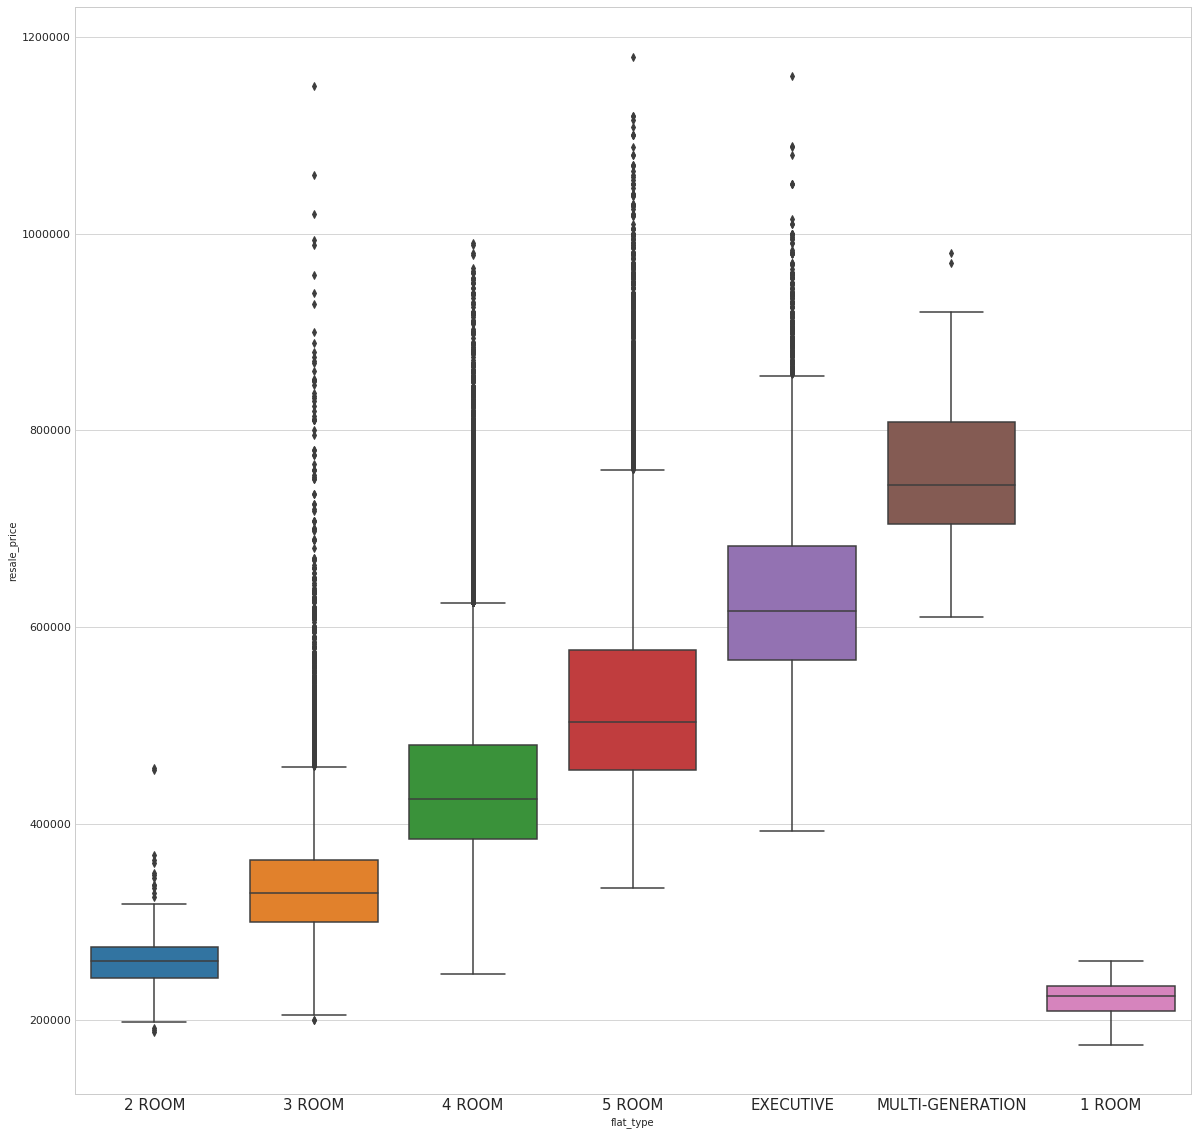

In [10]:
plt.figure(figsize=(20,20))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 11)


sns.boxplot(x=df.flat_type, y=df.resale_price)

### There are some 3 room flats which are more expensive than the most expensive 4 room and Multi Generation flats!

Those must be some really nice 3 room flats! Let's examine exactly what these flats are.



In [11]:
most_expensive_4room = df[df['flat_type'] == '4 ROOM'].sort_values('resale_price', ascending=False).iloc[0,-2]

In [12]:
df[df['flat_type'] == '4 ROOM'].sort_values('resale_price', ascending=False).iloc[0,-2]

990000.0

In [13]:
most_expensive_4room

990000.0

In [14]:
df[(df['flat_type'] == '3 ROOM') & (df['resale_price'] > most_expensive_4room)]


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_price_per_floor_area_sqm
24736,2013-04,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,01 TO 03,266.0,Terrace,1972,1020000.0,3834.586466
34554,2013-11,KALLANG/WHAMPOA,3 ROOM,59,JLN MA'MOR,01 TO 03,180.0,Terrace,1972,993888.0,5521.600000
56586,2015-03,KALLANG/WHAMPOA,3 ROOM,53,JLN MA'MOR,01 TO 03,280.0,Terrace,1972,1060000.0,3785.714286
89947,2016-12,KALLANG/WHAMPOA,3 ROOM,57,JLN MA'MOR,01 TO 03,259.0,Terrace,1972,1150000.0,4440.154440


### Looks like some of the properties labelled '3 ROOM' are actually Terrace houses. I also confirmed it with Google street view. 



In [15]:
df.loc[df['flat_type'] == '3 ROOM'].sort_values('resale_price', ascending=False)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_price_per_floor_area_sqm
89947,2016-12,KALLANG/WHAMPOA,3 ROOM,57,JLN MA'MOR,01 TO 03,259.0,Terrace,1972,1150000.00,4440.154440
56586,2015-03,KALLANG/WHAMPOA,3 ROOM,53,JLN MA'MOR,01 TO 03,280.0,Terrace,1972,1060000.00,3785.714286
24736,2013-04,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,01 TO 03,266.0,Terrace,1972,1020000.00,3834.586466
34554,2013-11,KALLANG/WHAMPOA,3 ROOM,59,JLN MA'MOR,01 TO 03,180.0,Terrace,1972,993888.00,5521.600000
12113,2012-08,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,01 TO 03,249.0,Terrace,1972,988888.00,3971.437751
61387,2015-06,KALLANG/WHAMPOA,3 ROOM,60,JLN BAHAGIA,01 TO 03,241.0,Terrace,1972,958000.00,3975.103734
45877,2014-08,KALLANG/WHAMPOA,3 ROOM,63,JLN MA'MOR,01 TO 03,118.0,Terrace,1972,940000.00,7966.101695
43297,2014-06,KALLANG/WHAMPOA,3 ROOM,64,JLN MA'MOR,01 TO 03,126.0,Terrace,1972,928000.00,7365.079365
41936,2014-05,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,01 TO 03,126.0,Terrace,1972,900000.00,7142.857143
94055,2017-03,QUEENSTOWN,3 ROOM,55,STIRLING RD,01 TO 03,84.0,Terrace,1968,888888.88,10582.010476


In [16]:
flat_group = df.groupby('flat_model')
order = flat_group.median().sort_values('resale_price', ascending=False).index

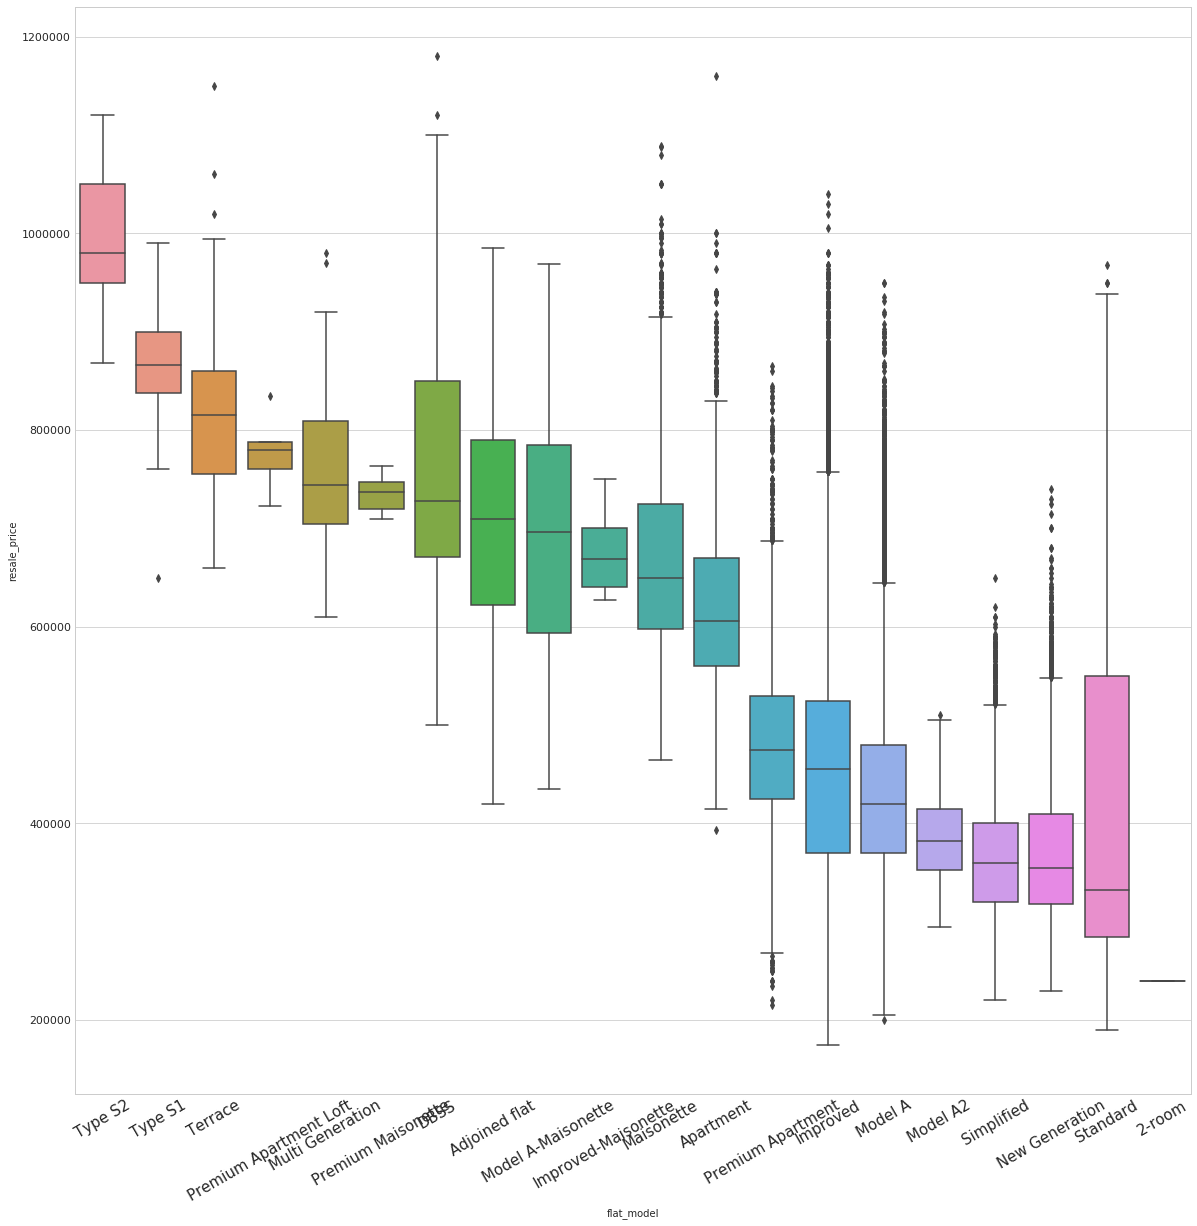

In [17]:

plt.figure(figsize=(20,20))
plt.xticks(fontsize = 15, rotation=30)
plt.yticks(fontsize = 11)

sns.boxplot(x=df.flat_model, y=df.resale_price, order=order)

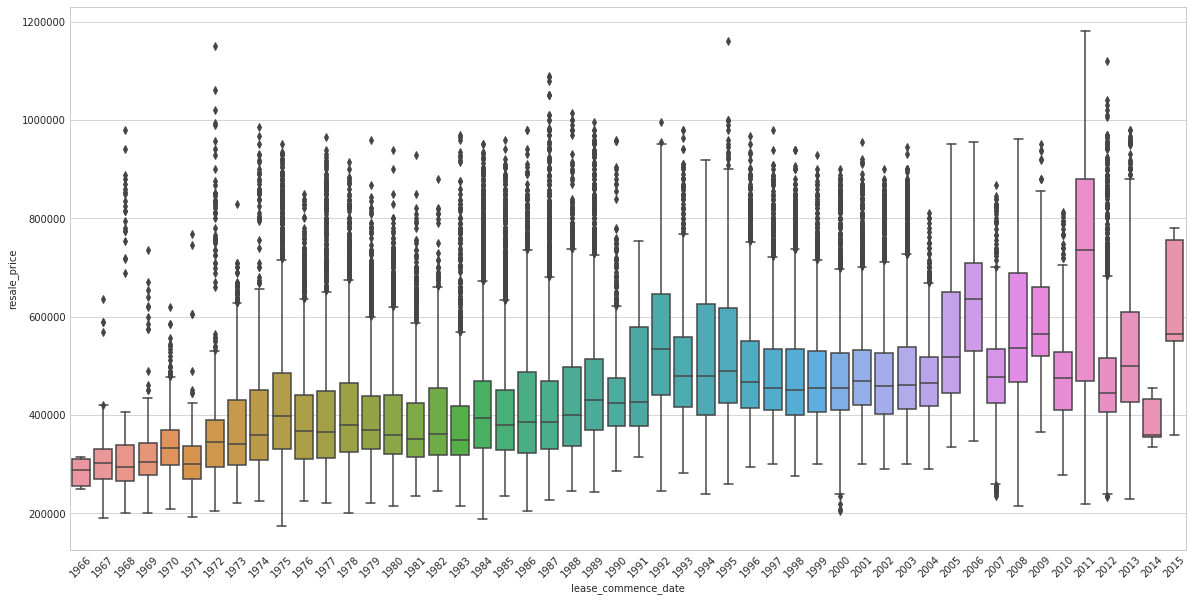

In [18]:

plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.boxplot(x=df.lease_commence_date, y=df.resale_price)

### 1.3 Distribution of our dependent variable

Resale price is right skewed, as expected. 

count    1.021000e+05
mean     4.498540e+05
std      1.310726e+05
min      1.750000e+05
25%      3.550000e+05
50%      4.250000e+05
75%      5.150000e+05
max      1.180000e+06
Name: resale_price, dtype: float64


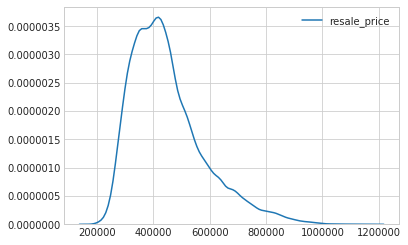

In [19]:
print df.resale_price.describe()
sns.kdeplot(df.resale_price)

# 2. Data Cleaning (Work in progress)

Prepping our data for modelling later.

### 2.1 Checking for outliers in our dependent variable.

By creating a scatterplot of resale_price vs floor_area_sqm. I noticed there are a number of very large houses, larger than 200 floor_area_sqm. We will examine these large houses.

In [20]:
df.resale_price.describe()

count    1.021000e+05
mean     4.498540e+05
std      1.310726e+05
min      1.750000e+05
25%      3.550000e+05
50%      4.250000e+05
75%      5.150000e+05
max      1.180000e+06
Name: resale_price, dtype: float64

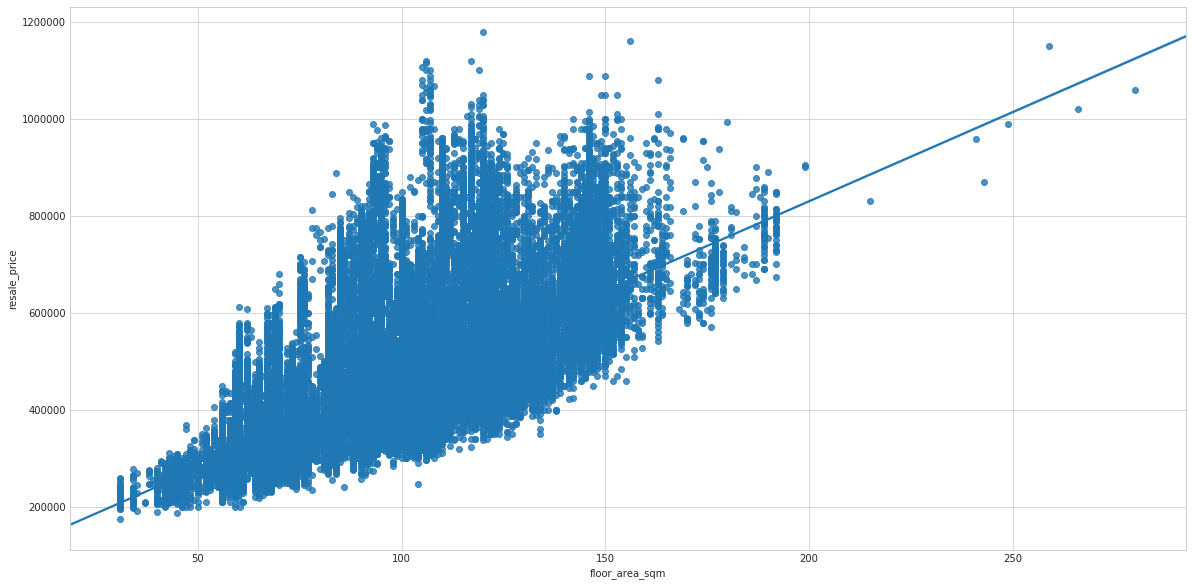

In [21]:
plt.figure(figsize=(20,10))
sns.regplot(x=df['floor_area_sqm'], y=df['resale_price'])

### Let's take a closer look at those big houses ( >= 200 square meters)

They are either Masionettes in Bishan, or Terrace houses in Kallang/Whampoa.

I decided to drop these records.

In [22]:
df.loc[df.floor_area_sqm >= 199]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_price_per_floor_area_sqm
2621,2012-04,BISHAN,EXECUTIVE,446,BRIGHT HILL DR,06 TO 10,243.0,Maisonette,1990,869000.0,3576.131687
12113,2012-08,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,01 TO 03,249.0,Terrace,1972,988888.0,3971.437751
24736,2013-04,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,01 TO 03,266.0,Terrace,1972,1020000.0,3834.586466
30126,2013-08,BISHAN,EXECUTIVE,443,SIN MING AVE,07 TO 09,199.0,Maisonette,1990,905000.0,4547.738693
56586,2015-03,KALLANG/WHAMPOA,3 ROOM,53,JLN MA'MOR,01 TO 03,280.0,Terrace,1972,1060000.0,3785.714286
61387,2015-06,KALLANG/WHAMPOA,3 ROOM,60,JLN BAHAGIA,01 TO 03,241.0,Terrace,1972,958000.0,3975.103734
71401,2016-01,BISHAN,EXECUTIVE,446,BRIGHT HILL DR,07 TO 09,199.0,Maisonette,1990,900000.0,4522.613065
89947,2016-12,KALLANG/WHAMPOA,3 ROOM,57,JLN MA'MOR,01 TO 03,259.0,Terrace,1972,1150000.0,4440.154440
99429,2017-06,KALLANG/WHAMPOA,3 ROOM,38,JLN BAHAGIA,01 TO 03,215.0,Terrace,1972,830000.0,3860.465116


In [23]:
df.drop(df.loc[df.floor_area_sqm >= 199].index, axis=0, inplace=True)

In [24]:
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_price_per_floor_area_sqm
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0,5555.555556
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0,6022.727273
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0,4632.352941
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0,4776.119403
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0,4791.044776
5,2012-03,ANG MO KIO,3 ROOM,154,ANG MO KIO AVE 5,01 TO 05,68.0,New Generation,1981,321000.0,4720.588235
6,2012-03,ANG MO KIO,3 ROOM,110,ANG MO KIO AVE 4,01 TO 05,67.0,New Generation,1978,323000.0,4820.895522
7,2012-03,ANG MO KIO,3 ROOM,445,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1979,325000.0,4850.746269
8,2012-03,ANG MO KIO,3 ROOM,476,ANG MO KIO AVE 10,11 TO 15,67.0,New Generation,1979,328000.0,4895.522388
9,2012-03,ANG MO KIO,3 ROOM,631,ANG MO KIO AVE 4,01 TO 05,67.0,New Generation,1985,330000.0,4925.373134


In [25]:
df.flat_model.value_counts()

Model A                   29394
Improved                  26384
New Generation            17907
Premium Apartment          9497
Simplified                 5609
Apartment                  4077
Standard                   3721
Maisonette                 2826
Model A2                   1583
DBSS                        427
Type S1                     175
Model A-Maisonette          160
Adjoined flat               154
Type S2                      68
Terrace                      59
Multi Generation             26
Improved-Maisonette          12
Premium Maisonette            6
Premium Apartment Loft        5
2-room                        1
Name: flat_model, dtype: int64

### 2.2 Converting data types

In [26]:
# Convert storey_range to a float by taking the median of storey_range

df.storey_range.value_counts()

df['storey_range'] = df.storey_range.str.split('TO', expand=True).astype(float).mean(axis=1)

df.rename(columns={'storey_range':'storey'})

,month,town,flat_type,block,street_name,storey,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_price_per_floor_area_sqm
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,8.0,45.0,Improved,1986,250000.0,5555.555556
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,3.0,44.0,Improved,1980,265000.0,6022.727273
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,8.0,68.0,New Generation,1980,315000.0,4632.352941
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,3.0,67.0,New Generation,1984,320000.0,4776.119403
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,8.0,67.0,New Generation,1980,321000.0,4791.044776
5,2012-03,ANG MO KIO,3 ROOM,154,ANG MO KIO AVE 5,3.0,68.0,New Generation,1981,321000.0,4720.588235
6,2012-03,ANG MO KIO,3 ROOM,110,ANG MO KIO AVE 4,3.0,67.0,New Generation,1978,323000.0,4820.895522
7,2012-03,ANG MO KIO,3 ROOM,445,ANG MO KIO AVE 10,3.0,67.0,New Generation,1979,325000.0,4850.746269
8,2012-03,ANG MO KIO,3 ROOM,476,ANG MO KIO AVE 10,13.0,67.0,New Generation,1979,328000.0,4895.522388
9,2012-03,ANG MO KIO,3 ROOM,631,ANG MO KIO AVE 4,3.0,67.0,New Generation,1985,330000.0,4925.373134


In [27]:
# Set month to datetime64 format

df['month'] = df['month'].astype('datetime64[ns]')

### When dealing with nominal categories, a good approach is to use one hot encoding.

In [28]:
df.head()

pd.get_dummies(df['flat_model'])

,2-room,Adjoined flat,Apartment,DBSS,Improved,Improved-Maisonette,Maisonette,Model A,Model A-Maisonette,Model A2,Multi Generation,New Generation,Premium Apartment,Premium Apartment Loft,Premium Maisonette,Simplified,Standard,Terrace,Type S1,Type S2
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [29]:
pd.get_dummies(df['town'])

pd.concat([df, pd.get_dummies(df['town'])], axis=1)



,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_price_per_floor_area_sqm,ANG MO KIO,BEDOK,BISHAN,BUKIT BATOK,BUKIT MERAH,BUKIT PANJANG,BUKIT TIMAH,CENTRAL AREA,CHOA CHU KANG,CLEMENTI,GEYLANG,HOUGANG,JURONG EAST,JURONG WEST,KALLANG/WHAMPOA,MARINE PARADE,PASIR RIS,PUNGGOL,QUEENSTOWN,SEMBAWANG,SENGKANG,SERANGOON,TAMPINES,TOA PAYOH,WOODLANDS,YISHUN
0,2012-03-01,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,8.0,45.0,Improved,1986,250000.0,5555.555556,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2012-03-01,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,3.0,44.0,Improved,1980,265000.0,6022.727273,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2012-03-01,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,8.0,68.0,New Generation,1980,315000.0,4632.352941,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2012-03-01,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,3.0,67.0,New Generation,1984,320000.0,4776.119403,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2012-03-01,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,8.0,67.0,New Generation,1980,321000.0,4791.044776,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2012-03-01,ANG MO KIO,3 ROOM,154,ANG MO KIO AVE 5,3.0,68.0,New Generation,1981,321000.0,4720.588235,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2012-03-01,ANG MO KIO,3 ROOM,110,ANG MO KIO AVE 4,3.0,67.0,New Generation,1978,323000.0,4820.895522,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2012-03-01,ANG MO KIO,3 ROOM,445,ANG MO KIO AVE 10,3.0,67.0,New Generation,1979,325000.0,4850.746269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2012-03-01,ANG MO KIO,3 ROOM,476,ANG MO KIO AVE 10,13.0,67.0,New Generation,1979,328000.0,4895.522388,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2012-03-01,ANG MO KIO,3 ROOM,631,ANG MO KIO AVE 4,3.0,67.0,New Generation,1985,330000.0,4925.373134,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
